# Input modelling

This notebook shows a basic workflow for choosing probability distributions.

Here, we already know which distributions to use (as we sampled from them to create our synthetic data), but the steps illustrate how you might select distributions in practice with real data.

There are two possible workflows, depending on whether you want to fit distributions manually or automatically using available packages.

> **Manual workflow**.
> 
> 1. **Identify distributions to test** based on knowledge of processes being modelled, and inspection of the data (times series and histogram).
> 2. **Determine parameters** for those distributions.
> 3. **Test goodness-of-fit** for each distribution.
> 
> **Automated workflow**.
> 
> 1. **Identify relevant distributions** using same workflow as manual.
> 2. **Use tool** to fit a range of distributions.

It's still important to identify relevant distributions in the automated workflow - even if you'll be testing a whole suite - as these tools:

* Won't notify you have **temporal patterns** (e.g. spikes in service length every Friday).
* May suggest distributions which mathematically fit but **contextually are inappropriate** (e.g. normal distribution for service times, which can't be negative).
* Overfitting - tool may suggest complex distribution, even if **simpler is sufficient**.

## Set-up

In [1]:
# Import required packages
from fitter import Fitter
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

In [2]:
# Import data
data = pd.read_csv("../inputs/NHS_synthetic.csv", dtype={
    "ARRIVAL_TIME": str,
    "SERVICE_TIME": str,
    "DEPARTURE_TIME": str
})

# Preview data
data.head()

ARRIVAL_DATE ARRIVAL_TIME SERVICE_DATE SERVICE_TIME DEPARTURE_DATE  \
0   2025-01-01         0001   2025-01-01         0007     2025-01-01   
1   2025-01-01         0002   2025-01-01         0004     2025-01-01   
2   2025-01-01         0003   2025-01-01         0010     2025-01-01   
3   2025-01-01         0007   2025-01-01         0014     2025-01-01   
4   2025-01-01         0010   2025-01-01         0012     2025-01-01   

  DEPARTURE_TIME  
0           0012  
1           0007  
2           0030  
3           0022  
4           0031

Calculate inter-arrival times.

In [3]:
# Combine date/time and convert to datetime
data["arrival_datetime"] = pd.to_datetime(
    data["ARRIVAL_DATE"] + " " + data["ARRIVAL_TIME"].str.zfill(4),
    format="%Y-%m-%d %H%M"
)

# Sort by arrival time and calculate inter-arrival times
data = data.sort_values("arrival_datetime")
data["iat_mins"] = (
    data["arrival_datetime"].diff().dt.total_seconds() / 60
)

Calculate service times.

In [4]:
# Combine dates with times
data["service_datetime"] = pd.to_datetime(
    data["SERVICE_DATE"] + " " + data["SERVICE_TIME"].str.zfill(4)
)
data["departure_datetime"] = pd.to_datetime(
    data["DEPARTURE_DATE"] + " " + data["DEPARTURE_TIME"].str.zfill(4)
)

# Calculate time difference in minutes
time_delta = data["departure_datetime"] - data["service_datetime"]
data["service_mins"] = time_delta / pd.Timedelta(minutes=1)

## Both workflows: Identify relevant distributions

First, we consider our **knowledge about the process being modelled**. In this case, we have random arrivals and service times in a queueing model, which are often modelled using exponential distributions.

Then, we **inspect the data** in two different ways:

| Plot type | What does it show? | Why do we create this plot? |
| - | - | - |
| **Time series** | Trends, seasonality, and outliers (e.g., spikes or dips over time). | To check for **stationarity** (i.e. no trends or sudden changes). Stationary is an assumption of many distributions, and if trends or anomalies do exist, we may need to exclude certain periods or model them separately. The time series can also be useful for spotting outliers and data gaps. |
| **Histogram** | The shape of the data's distribution. | Helps **identify which distributions might fit** the data. |

We repeat this for arrivals and service time, so have created a function to avoid duplicate code between each.

In [5]:
def inspect_time_series(series, y_lab):
    """
    Plot time-series.

    Parameters
    ----------
    series : pd.Series
        Series containing the time series data (where index is the date).
    y_lab : str
        Y axis label.
    """
    # Label as "Date" and provided y_lab, and convert to dataframe
    df = series.rename_axis("Date").reset_index(name=y_lab)

    # Create plot
    fig = px.line(df, x="Date", y=y_lab)
    fig.update_layout(showlegend=False, width=700, height=400)
    fig.show()


def inspect_histogram(series, x_lab):
    """
    Plot histogram.

    Parameters
    ----------
    series : pd.Series
        Series containing the values to plot as a histogram.
    x_lab : str
        X axis label.
    """
    fig = px.histogram(series)
    fig.update_layout(
        xaxis_title=x_lab, showlegend=False, width=700, height=400
    )
    fig.update_traces(
        hovertemplate=x_lab + ": %{x}<br>Count: %{y}", name=""
    )
    fig.show()

### Arrivals

Daily arrivals - no trends/seasonality/outliers.

In [6]:
# Calculate mean arrivals per day and plot time series
inspect_time_series(series=data.groupby(by=["ARRIVAL_DATE"]).size(),
                    y_lab="Number of arrivals")

Distribution of inter-arrival times. Based on this, would try exponential, gamma and Weibull distributions.

In [7]:
# Plot histogram of inter-arrival times
inspect_histogram(series=data["iat_mins"],
                  x_lab="Inter-arrival time (min)")

### Service times

Daily mean service time - no trends/seasonality/outliers.

In [8]:
# Calculate mean service length per day, dropping last day (incomplete)
daily_service = data.groupby("SERVICE_DATE")["service_mins"].mean()
daily_service = daily_service.iloc[:-1]

# Plot time series
inspect_time_series(series=daily_service,
                    y_lab="Mean consultation length (min)")

Distribution of service times. Based on this, would try exponential, gamma and Weibull distributions.

In [9]:
# Plot histogram of service times
inspect_histogram(series=data["service_mins"],
                  x_lab="Consultation length (min)")

## Manual: Fit chosen distributions

Fit our chosen statistical distributions (exponential, gamma, weibull) to the data and assess goodness-of-fit. A common test to use is the **Kolmogorov-Smirnov (KS) Test**, which is well-suited to continuos distributions. For categorical (or binned) data, consider using a **chi-squared tests**.

The KS Test returns a statistic and p value.

* **Statistic:** Measures how well the distribution fits your data.
    * **Higher values indicate a better fit**.
    * Ranges from 0 to 1.
* **P-value:** Tells you if the fit could have happened by chance.
    * **Higher p-values suggest the data follow the distribution**.
    * In large datasets, even good fits often have small p-values.
    * Ranges from 0 to 1.

Probability of observing test statistic as extreme as, or more extreme than, the observed value under the null hypothesis. Higher p-values suggest data follow the distribution, very low p-values (e.g. <0.05) suggest the data does not.

In [10]:
def fit_distributions(data, dists):
    """
    This function fits statistical distributions to the provided data and
    performs Kolmogorov-Smirnov tests to assess the goodness of fit.

    Parameters
    ----------
    data : array_like
        The observed data to fit the distributions to.
    dists : list
        List of the distributions in scipy.stats to fit, eg. ["expon", "gamma"]

    Notes
    -----
    A lower test statistic and higher p-value indicate a better fit to the data.
    """
    for dist_name in dists:
        # Fit distribution to the data
        dist = getattr(stats, dist_name)
        params = dist.fit(data)

        # Return results from Kolmogorov-Smirnov test
        ks_result = stats.kstest(data, dist_name, args=params)
        print(f"Kolmogorov-Smirnov statistic for {dist_name}: " +
            f"{ks_result.statistic:.4f} (p={ks_result.pvalue:.2e})")


# Fit and run Kolmogorov-Smirnov test on the inter-arrival and service times
distributions = ["expon", "gamma", "weibull_min"]

print("Inter-arrival time")
fit_distributions(data=data["iat_mins"].dropna(), dists=distributions)

print("Service time")
fit_distributions(data=data["service_mins"], dists=distributions)

Inter-arrival time
Kolmogorov-Smirnov statistic for expon: 0.1155 (p=0.00e+00)
Kolmogorov-Smirnov statistic for gamma: 0.2093 (p=0.00e+00)
Kolmogorov-Smirnov statistic for weibull_min: 0.1355 (p=0.00e+00)
Service time
Kolmogorov-Smirnov statistic for expon: 0.0480 (p=3.08e-264)
Kolmogorov-Smirnov statistic for gamma: 0.1226 (p=0.00e+00)
Kolmogorov-Smirnov statistic for weibull_min: 0.0696 (p=0.00e+00)


Unsurprisingly, the best fit for both is the **exponential distribution** (lowest test statistic).

We can create a version of our histograms from before but with the distributions overlaid, to visually support this.

In [11]:
def inspect_histogram_with_fits(series, x_lab, dist_name):
    """
    Plot histogram with overlaid fitted distributions.

    Parameters
    ----------
    series : pd.Series
        Series containing the values to plot as a histogram.
    x_lab : str
        X axis label.
    dist_name : str
        Name of the distributions in scipy.stats to fit, eg. "expon"
    """
    # Plot histogram with probability density normalization
    fig = px.histogram(series, nbins=30, histnorm='probability density')
    fig.update_layout(
        xaxis_title=x_lab, showlegend=True, width=700, height=400
    )
    
    # Fit and plot each distribution
    x = np.linspace(series.min(), series.max(), 1000)
    dist = getattr(stats, dist_name)
    params = dist.fit(series.dropna())
    pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    fig.add_trace(go.Scatter(x=x, y=pdf_fitted, mode='lines', name=dist_name))
    
    fig.show()


In [12]:
# Plot histogram with fitted distribution
inspect_histogram_with_fits(series=data["iat_mins"].dropna(), 
                            x_lab="Inter-arrival time (min)", 
                            dist_name="expon")
inspect_histogram_with_fits(series=data["service_mins"], 
                            x_lab="Service time (min)", 
                            dist_name="expon")

## Automated: Use tool to fit distributions

There are various possible tools to use. One of the most popular is `Fitter` (available via [pypi](https://pypi.org/project/fitter/) or [bioconda](https://anaconda.org/bioconda/fitter) - though as of May 2024, it is more up-to-date on pypi), which also uses the `scipy` library (like above), but will fit to all eighty scipy distributions (rather than just those you specify), and return a summary of the best distributions. It will give:

* **sumsquare_error**: Sum of squared differences between your data and the fitted distribution.
    * Lower value indicates better fit.
* **aic**: Akaike Information Criterion. Balances goodness-of-fit against model complexity.
    * Lower values are better.
* **bic**: Bayesian Information Criterion. Similar to AIC but greater penalty on complexity, especially for large datasets.
    * Lower values are better.
* **kl_div**: Kullback-Leibler Divergence. Measure of how one probability distribution diverges from another.
* **ks_statistic** and **ks_pvalue**: Kolmogorov-Smirnov test. As described above, but as a reminder-
    * Lower statistic values indicate better fit.
    * Higher p-values indicate better fit.

**Note:** This can take a while as it's testing lots of distributions.

2025-05-08 16:50:10.100 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-05-08 16:50:10.486 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.294476)
2025-05-08 16:50:10.850 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.341129)
2025-05-08 16:50:11.152 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted dgamma distribution with error=0.341959)
2025-05-08 16:50:11.235 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.509284)
2025-05-08 16:50:11.605 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted dweibull distribution with error=0.352536)
2025-05-08 16:50:13.213 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.304028)
2025-05-08 16:50:13.257 | INFO     | fitter.fitter:_fit_single_distribution:333 - 

sumsquare_error          aic          bic  kl_div  \
genpareto                  0.294367  1390.297348  1419.667088     inf   
exponnorm                  0.294428  1383.434685  1412.804424     inf   
laplace_asymmetric         0.294434  1383.308700  1412.678439     inf   
truncpareto                0.294474  1388.628767  1427.788420     inf   
genexpon                   0.294475  1390.787326  1439.736891     inf   

                    ks_statistic  ks_pvalue  
genpareto               0.115461        0.0  
exponnorm               0.114264        0.0  
laplace_asymmetric      0.115394        0.0  
truncpareto             0.115461        0.0  
genexpon                0.115461        0.0

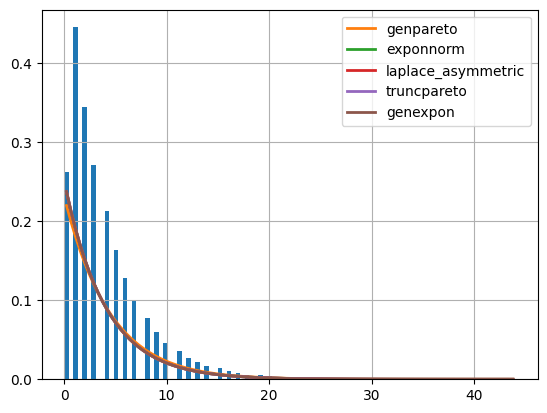

In [13]:
# Run Fitter on the inter-arrival times
f = Fitter(data["iat_mins"].dropna())
f.fit()
f.summary()

2025-05-08 16:53:15.534 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-05-08 16:53:15.821 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.003019)
2025-05-08 16:53:16.441 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.014974)
2025-05-08 16:53:16.450 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.011602)
2025-05-08 16:53:16.529 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted dgamma distribution with error=0.013033)
2025-05-08 16:53:16.921 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted dweibull distribution with error=0.012196)
2025-05-08 16:53:17.389 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.036016)
2025-05-08 16:53:17.532 | INFO     | fitter.fitter:_fit_single_distribution:333 - 

sumsquare_error          aic          bic  kl_div  ks_statistic  \
mielke           0.002450  1554.499029  1593.658712     inf      0.095524   
chi              0.002604  2497.935462  2527.305224     inf      0.089911   
erlang           0.002806  1575.104189  1604.473951     inf      0.077035   
pearson3         0.002810  1620.080067  1649.449829     inf      0.060152   
chi2             0.002926  1678.767604  1708.137366     inf      0.061503   

          ks_pvalue  
mielke          0.0  
chi             0.0  
erlang          0.0  
pearson3        0.0  
chi2            0.0

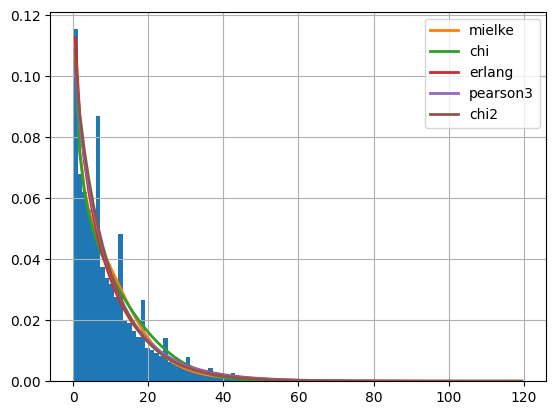

In [14]:
# Run Fitter on the service times
f = Fitter(data["service_mins"])
f.fit()
f.summary()

Results for for the five top distributions on each are quite similar to each other.

<mark>How do you choose what to use?</mark>

Another popular tool: https://github.com/erdogant/distfit